# Question 1

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label
rand_seed = 42
roll_number = 2021101113
L = ((roll_number%5)+1)*100
print(L)
p_values = [0.3, 0.4,0.7]

400


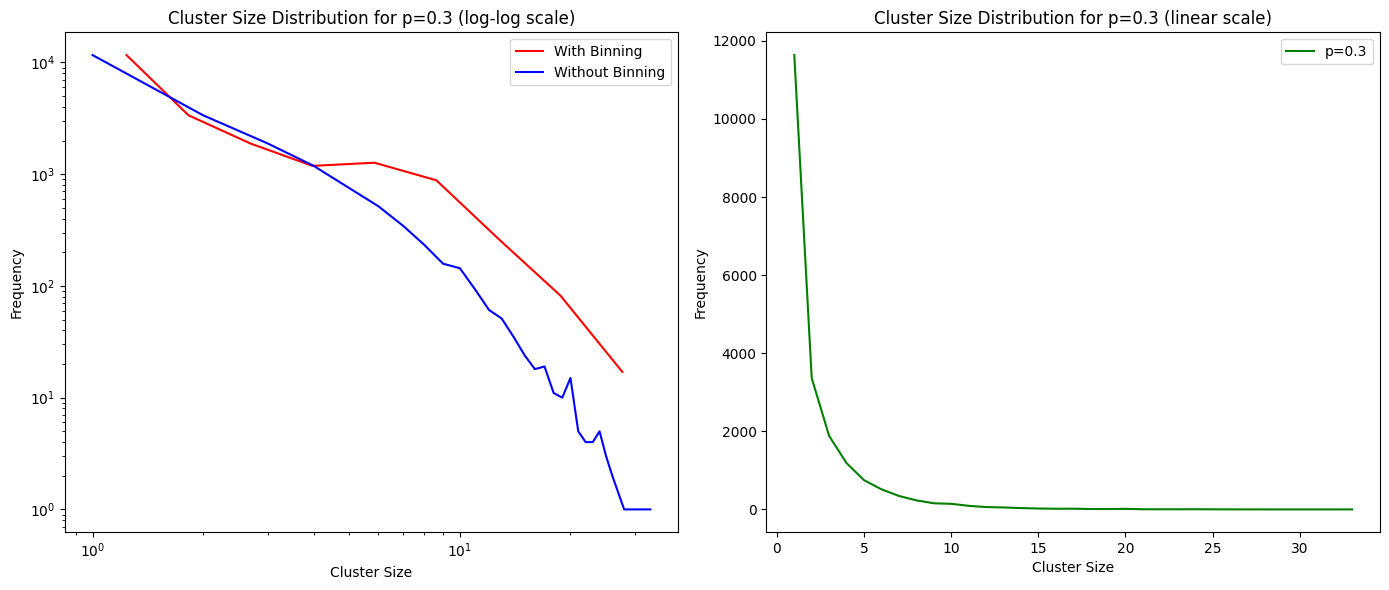

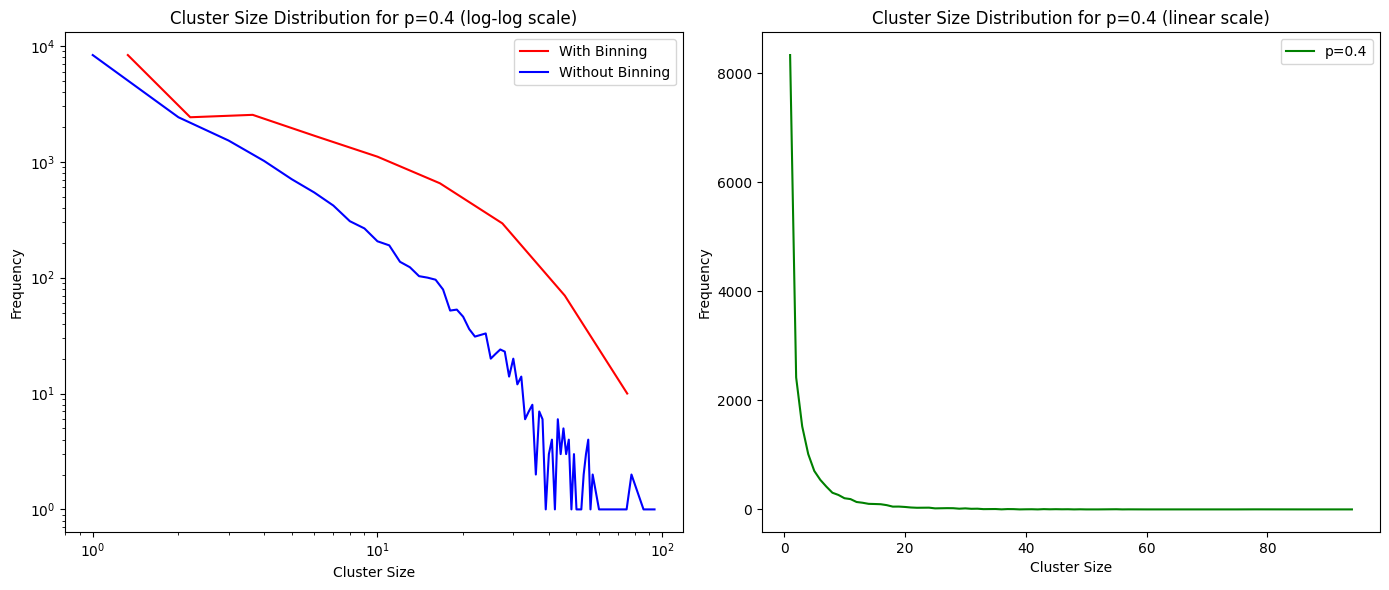

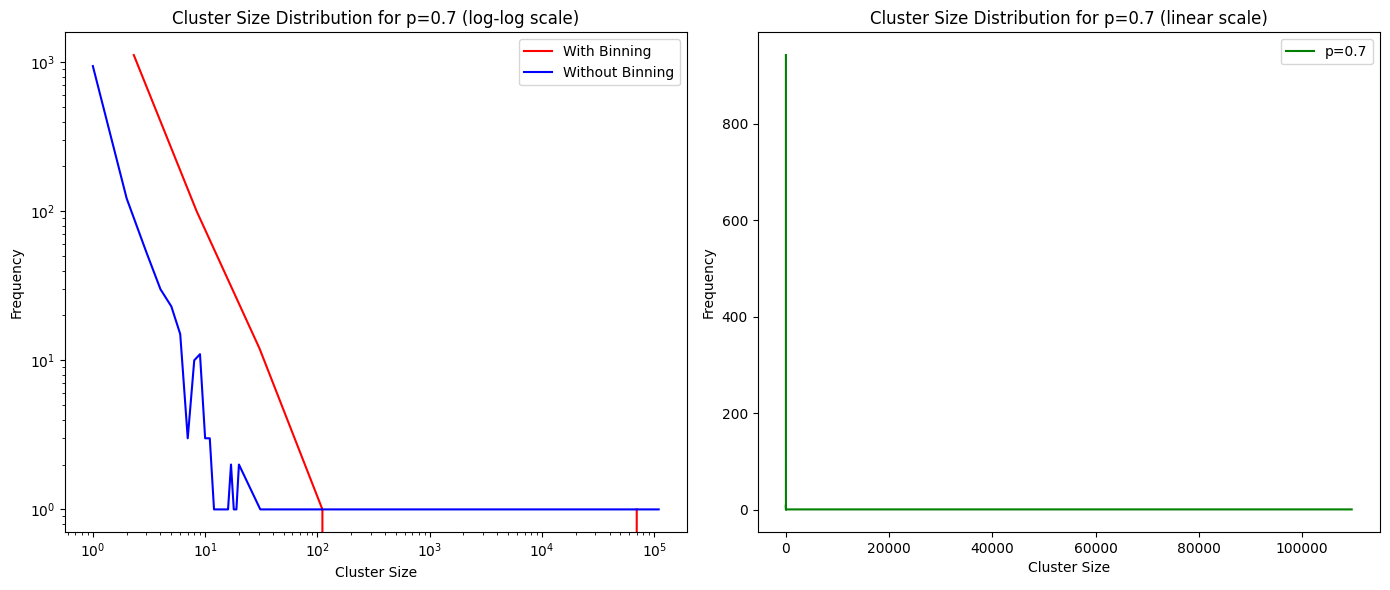

In [8]:
def compute_cluster_sizes(lattice):
    labels, _ = label(lattice)
    cluster_sizes = np.bincount(labels.ravel())[1:] 
    return cluster_sizes

def plot_distribution(p, rand_seed=42, L=100, for_critical=False):
    np.random.seed(rand_seed)
    lattice = np.random.rand(L, L) < p  # Create lattice with given p
    cluster_sizes = compute_cluster_sizes(lattice)
    logbins = np.logspace(0, np.log10(max(cluster_sizes)), num=10)
    counts, edges = np.histogram(cluster_sizes, bins=logbins)
    centers = (edges[:-1] + edges[1:]) / 2
    unique_sizes, freq = np.unique(cluster_sizes, return_counts=True)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].loglog(centers, counts, 'r-', label='With Binning')
    axes[0].loglog(unique_sizes, freq, 'b-', label='Without Binning')
    axes[0].set_title(f'Cluster Size Distribution for p={p} (log-log scale)')
    axes[0].set_xlabel('Cluster Size')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[1].plot(unique_sizes, freq, 'g-', label=f'p={p}')
    axes[1].set_title(f'Cluster Size Distribution for p={p} (linear scale)')
    axes[1].set_xlabel('Cluster Size')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    plt.tight_layout()
    plt.show()
    if(for_critical):
        x = np.log10(unique_sizes)
        y = np.log10(freq)
        slope = np.polyfit(x, y, 1)[0]
        print('For p = p_critical, exponent is: ', slope)

for p in p_values:
    plot_distribution(p, rand_seed, L)

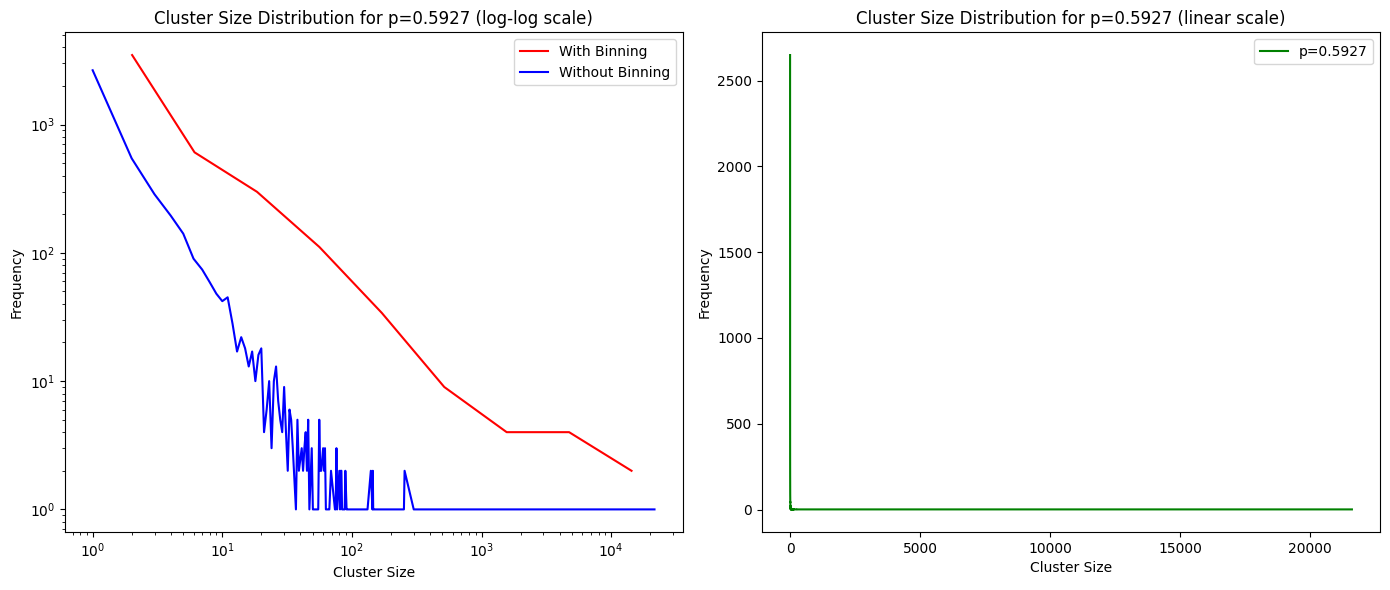

For p = p_critical, exponent is:  -0.680597677361391


In [9]:
plot_distribution(0.5927, rand_seed, L, for_critical=True)

# Question 2

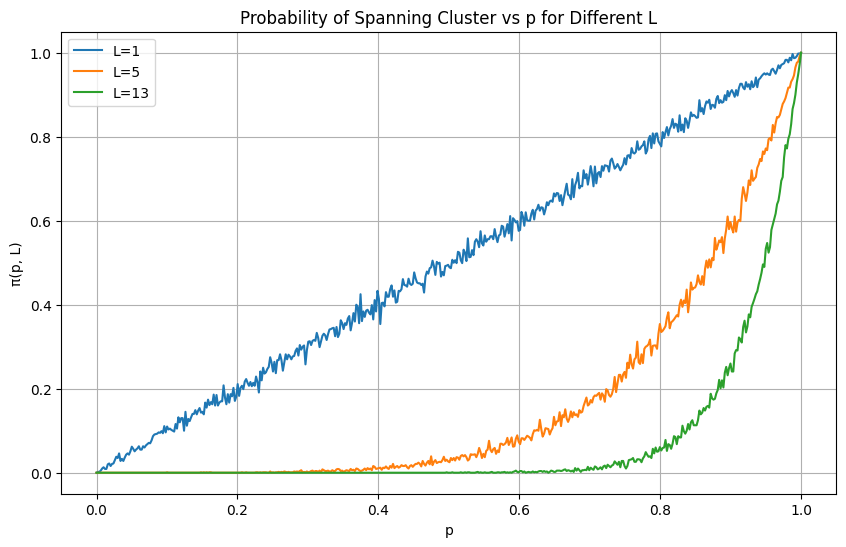

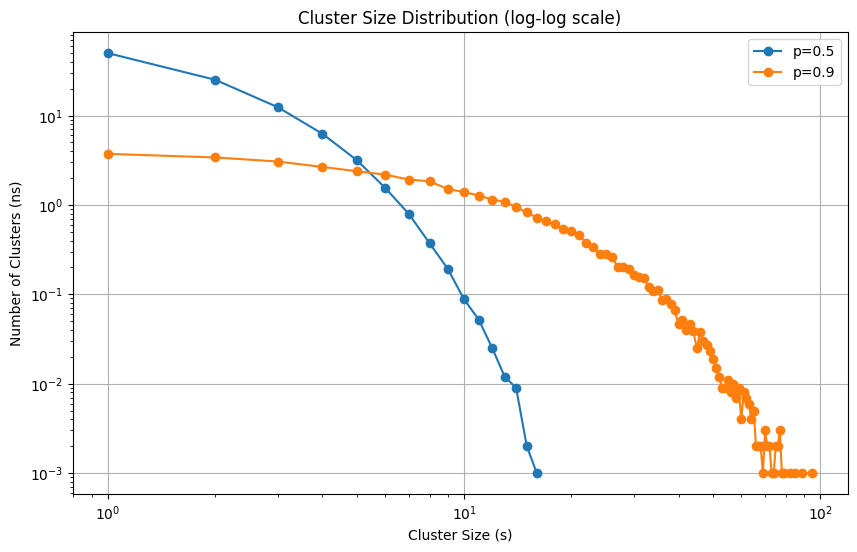

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

def create_lattice(L, p):
    """Create a 1D lattice of size L with occupation probability p."""
    return np.random.rand(L) < p

def has_spanning_cluster(lattice):
    """Check if there is a spanning cluster in the lattice."""
    labeled, num_features = label(lattice)
    if num_features == 0:
        return False
    for i in range(1, num_features + 1):
        if np.any(labeled == i) and np.all(labeled == i):
            return True
    return False

def calculate_pi(p, L, num_samples=1000):
    """Calculate the probability of having a spanning cluster for given p and L."""
    spanning_count = 0
    for _ in range(num_samples):
        lattice = create_lattice(L, p)
        if has_spanning_cluster(lattice):
            spanning_count += 1
    return spanning_count / num_samples

def calculate_ns(lattice):
    """Calculate the number of clusters of size s."""
    labeled, num_features = label(lattice)
    cluster_sizes = np.bincount(labeled.ravel())
    return cluster_sizes[1:]

def plot_pi_vs_p(L_values, p_values, num_samples=1000):
    """Plot π(p, L) as a function of p for various L."""
    plt.figure(figsize=(10, 6))
    for L in L_values:
        pi_values = [calculate_pi(p, L, num_samples) for p in p_values]
        plt.plot(p_values, pi_values, label=f'L={L}')
    plt.xlabel('p')
    plt.ylabel('π(p, L)')
    plt.title('Probability of Spanning Cluster vs p for Different L')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_ns_vs_s(L, p_values, num_samples=1000):
    """Plot ns vs s for various values of p."""
    plt.figure(figsize=(10, 6))
    for p in p_values:
        ns_values = []
        for _ in range(num_samples):
            lattice = create_lattice(L, p)
            ns = calculate_ns(lattice)
            ns_values.extend(ns)
        s_values, counts = np.unique(ns_values, return_counts=True)
        plt.loglog(s_values, counts / num_samples, 'o-', label=f'p={p}')
    plt.xlabel('Cluster Size (s)')
    plt.ylabel('Number of Clusters (ns)')
    plt.title('Cluster Size Distribution (log-log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()


L_values = [1, 5, 13]  
p_values = np.linspace(0, 1, 500)  
num_samples = 1000


plot_pi_vs_p(L_values, p_values, num_samples)

L_fixed = 400
p_values_ns = [0.5, 0.9]
plot_ns_vs_s(L_fixed, p_values_ns, num_samples)

# Question 3

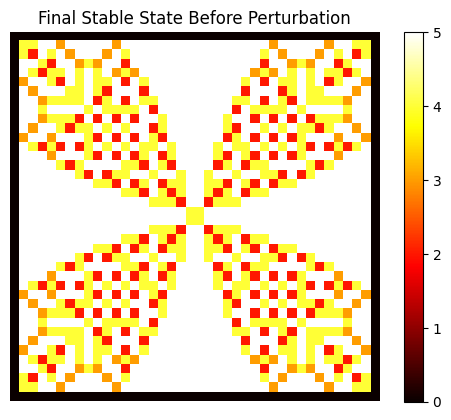

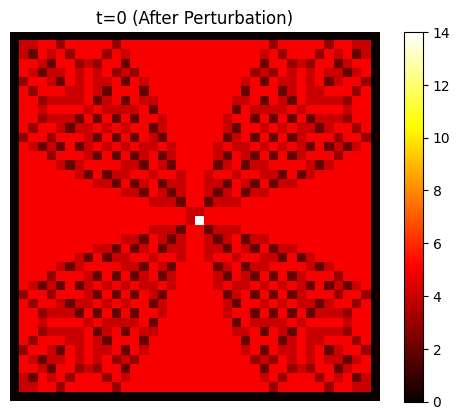

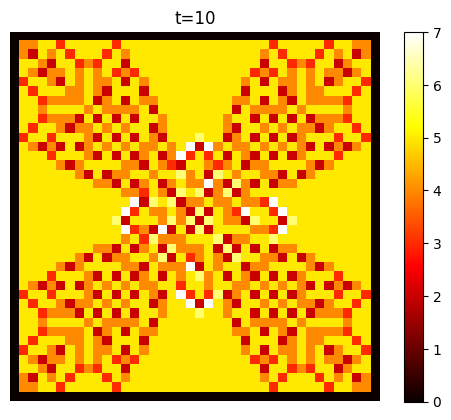

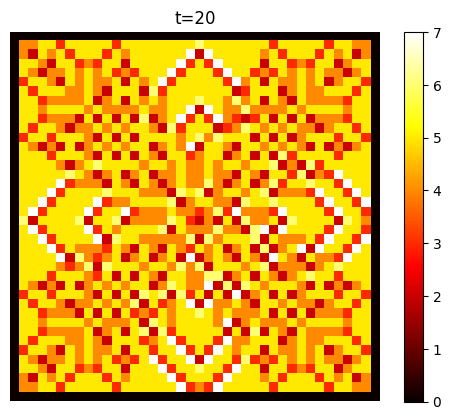

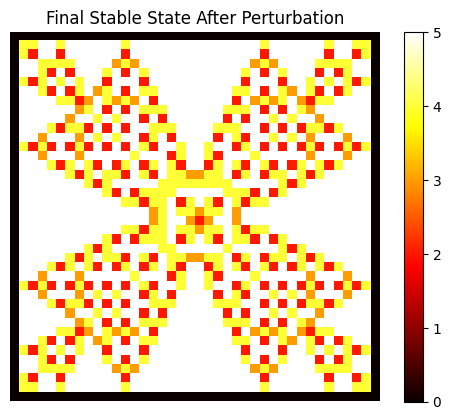

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def initialize_lattice(L, threshold):
    """Initialize LxL lattice with all sites at the threshold and fixed boundary condition."""
    lattice = np.full((L, L), threshold)
    lattice[0, :] = lattice[:, 0] = lattice[-1, :] = lattice[:, -1] = 0  # Fixed boundaries
    return lattice

def stabilize(lattice, threshold):
    """Run the sandpile model until stabilization."""
    L = lattice.shape[0]
    stable = False
    while not stable:
        stable = True
        for i in range(1, L - 1):
            for j in range(1, L - 1):
                if lattice[i, j] >= threshold:
                    lattice[i, j] -= 4
                    if i > 1: lattice[i-1, j] += 1
                    if i < L-2: lattice[i+1, j] += 1
                    if j > 1: lattice[i, j-1] += 1
                    if j < L-2: lattice[i, j+1] += 1
                    stable = False
    return lattice

def apply_perturbation(lattice, perturbation, center):
    """Apply perturbation at the given center."""
    cx, cy = center
    lattice[cx, cy] += perturbation

def evolve_until_stable(lattice, threshold):
    """Evolve the system until it stabilizes after perturbation, ensuring snapshots at t=0, t=10, t=20."""
    L = lattice.shape[0]
    snapshots = [lattice.copy()]  
    
    stable = False
    t = 0
    while not stable or t < 20:
        stable = True
        new_lattice = lattice.copy()
        
        for i in range(1, L - 1):
            for j in range(1, L - 1):
                if lattice[i, j] >= threshold:
                    new_lattice[i, j] -= 4
                    if i > 1: new_lattice[i-1, j] += 1
                    if i < L-2: new_lattice[i+1, j] += 1
                    if j > 1: new_lattice[i, j-1] += 1
                    if j < L-2: new_lattice[i, j+1] += 1
                    stable = False
        
        lattice[1:L-1, 1:L-1] = new_lattice[1:L-1, 1:L-1]  
        t += 1
        
        if t == 10 or t == 20:
            snapshots.append(lattice.copy())  
    
    snapshots.append(lattice.copy())  
    return snapshots

def plot_lattice(lattice, title):
    """Plot a given lattice configuration with improved colormap."""
    plt.imshow(lattice, cmap='hot', interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()


roll_number = 2021101113
L = ((roll_number % 7) + 1) * 10
threshold = (roll_number % 5) + 3
perturbation = 10  
center = (L // 2, L // 2)  


lattice = initialize_lattice(L, threshold)
lattice = stabilize(lattice, threshold)
plot_lattice(lattice, "Final Stable State Before Perturbation")


apply_perturbation(lattice, perturbation, center)
snapshots = evolve_until_stable(lattice, threshold)


plot_lattice(snapshots[0], "t=0 (After Perturbation)")
if len(snapshots) > 1:
    plot_lattice(snapshots[1], "t=10")
if len(snapshots) > 2:
    plot_lattice(snapshots[2], "t=20")
plot_lattice(snapshots[-1], "Final Stable State After Perturbation")